<a href="https://colab.research.google.com/github/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/blob/main/proyecto_churninsight_prediccion_de_cancelacion_de_clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📉 Proyecto ChurnInsight: Predicción de Cancelación de Clientes
**Autor:** Daisy Quinteros Silva
<br>
**Rol:** Data Scientist
<br>
**Fecha:** Enero 2026

## 🎯 Objetivo
Desarrollar un modelo de Machine Learning capaz de predecir la probabilidad de abandono (Churn) de clientes de una empresa de telecomunicaciones, basado en su comportamiento histórico y transaccional.

## ⚙️ Stack Tecnológico
* **Lenguaje:** Python 3.10+
* **Librerías Principales:** Pandas, Scikit-learn, Seaborn.
* **Modelo:** Random Forest Classifier.
* **Métrica Principal:** Accuracy & Recall.

---

##**Extracción**

###**Importando las librerias y cargando el data set desde GitHub**

In [2]:
#importando las librerias
import pandas as pd
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Control de versiones

In [26]:
# Instalamos watermark para documentar versiones
!pip install -q watermark

# Imprimimos las versiones exactas usadas en este entorno
%load_ext watermark
%watermark -a "Daisy" -v -p pandas,numpy,sklearn,matplotlib,seaborn,joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00
Author: Daisy

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 7.34.0

pandas    : 2.2.2
numpy     : 2.0.2
sklearn   : 1.6.1
matplotlib: 3.10.0
seaborn   : 0.13.2
joblib    : 1.5.3



In [3]:


# FUNCIÓN MAESTRA DE CARGA
def cargar_desde_github(url_raw, nombre_archivo="dataset"):
    """
    Lee un CSV desde GitHub Raw forzando UTF-8 y manejando errores comunes.
    """
    try:
        print(f"📡 Conectando a {nombre_archivo}...")

        # 1. Hacemos la petición web (Request)
        response = requests.get(url_raw)
        response.raise_for_status() # Lanza error si el link está roto (404)

        # 2. Decodificamos el contenido forzando UTF-8
        # Esto asegura que tildes, ñ y caracteres especiales se lean bien en cualquier navegador
        contenido_texto = response.content.decode('utf-8')

        # 3. Convertimos el texto en un DataFrame
        df = pd.read_csv(io.StringIO(contenido_texto), sep=',')

        print(f"✅ {nombre_archivo} cargado exitosamente: {df.shape[0]} filas, {df.shape[1]} columnas.")
        return df

    except requests.exceptions.HTTPError as err:
        print(f"❌ Error: El enlace está roto o es privado. Verifica la URL Raw.\nDetalle: {err}")
    except pd.errors.ParserError:
        print(f"❌ Error: El archivo no parece ser un CSV válido o el separador no es coma.")
    except Exception as e:
        print(f"❌ Error inesperado: {e}")
        return None

# --- TUS URLS RAW (Reemplaza estas líneas con TUS links reales) ---
# Ejemplo: 'https://raw.githubusercontent.com/TU_USUARIO/TU_REPO/main/base_clientes_real.csv'

url_clientes = "https://raw.githubusercontent.com/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/refs/heads/main/base_clientes_real.csv"
url_logs     = "https://raw.githubusercontent.com/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/refs/heads/main/base_logs_real.csv"
url_finanzas = "https://raw.githubusercontent.com/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/refs/heads/main/base_facturacion_real.csv"

# --- EJECUCIÓN DE LA CARGA ---
# Solo ejecutará si has puesto los links, si no, te avisará.
if "PEGAR_AQUI" not in url_clientes:
    df_clientes = cargar_desde_github(url_clientes, "Tabla Clientes")
    df_logs = cargar_desde_github(url_logs, "Tabla Logs")
    df_facturacion = cargar_desde_github(url_finanzas, "Tabla Facturación")
else:
    print("⚠️ ¡Atención! Debes pegar tus links RAW de GitHub en las variables de arriba para continuar.")

📡 Conectando a Tabla Clientes...
✅ Tabla Clientes cargado exitosamente: 1800 filas, 4 columnas.
📡 Conectando a Tabla Logs...
✅ Tabla Logs cargado exitosamente: 1800 filas, 3 columnas.
📡 Conectando a Tabla Facturación...
✅ Tabla Facturación cargado exitosamente: 1800 filas, 4 columnas.


**Notas:**<br>
¿Por qué este esquema es mejor que un simple pd.read_csv()?
<br>
**requests.get(url).content.decode('utf-8'):** Esta es la clave. A veces GitHub sirve los archivos con encabezados extraños. Al descargar el contenido y decodificarlo explícitamente antes de pasarlo a Pandas, garantizas que Windows, Mac y Linux lean los caracteres igual.

**io.StringIO:** Convierte ese texto en un "archivo virtual" en memoria, lo que es mucho más rápido y seguro que guardar temporales en el disco.

**sep=',':** Aunque es el defecto, es mejor ser explícito por si subes un CSV separado por punto y coma (común en Excel en español).

###**Uniendo las tablas de datos**

Vamos a usar el customer_id como la llave para conectar las tablas. Usaremos un inner join, lo que significa que solo nos quedaremos con los clientes que existan en las tres tablas (para asegurar que tenemos datos completos de todos).



In [4]:
#Código de Merge (Unificación)

# Paso A: Unir Clientes + Logs
# Usamos 'how=inner' para asegurar intersección exacta
df_temp = pd.merge(df_clientes, df_logs, on='customer_id', how='inner')
print(f"   -> Unión 1 (Clientes + Logs): {df_temp.shape[0]} filas")

# Paso B: Unir el resultado anterior + Finanzas
df_master = pd.merge(df_temp, df_facturacion, on='customer_id', how='inner')
print(f"   -> Unión 2 (+ Finanzas): {df_master.shape[0]} filas")

# --- VALIDACIÓN DE INTEGRIDAD ---
# Es vital verificar que no se hayan disparado las filas (duplicados)
# ni que tengamos columnas con nombres raros (ej: tenure_x, tenure_y)

print("\n2. Dataset Maestro Generado:")
print(f"   Dimensiones finales: {df_master.shape}")
print(f"   Columnas: {df_master.columns.tolist()}")

# --- VISTA PREVIA DEL PROBLEMA ---
# Miremos las primeras filas para confirmar que la unión trajo la 'suciedad'
# que debemos limpiar en el siguiente paso.
print("\n3. Muestra de datos (Observa 'tenure' y 'total_spend'):")
print(df_master[['customer_id', 'tenure', 'total_spend', 'churn']].head(5))

   -> Unión 1 (Clientes + Logs): 1800 filas
   -> Unión 2 (+ Finanzas): 1800 filas

2. Dataset Maestro Generado:
   Dimensiones finales: (1800, 9)
   Columnas: ['customer_id', 'tenure', 'contract_type', 'subscription_type', 'usage_time', 'login_frequency', 'payment_record', 'total_spend', 'churn']

3. Muestra de datos (Observa 'tenure' y 'total_spend'):
  customer_id  tenure         total_spend  churn
0   REAL-1438   113.0               62.97      0
1   REAL-3674    67.0  45.510000000000005      0
2   REAL-2345    98.0               21.09      1
3   REAL-2957   147.0               60.56      0
4   REAL-3148    96.0               53.83      0


##**Conociendo el conjunto de datos**

###**Explorando las columnas del dataset y verificando sus tipos de datos.**

In [5]:
df_master

,customer_id,tenure,contract_type,subscription_type,usage_time,login_frequency,payment_record,total_spend,churn
0,REAL-1438,113.0,Month-to-Month,Basic,675.0,93,Good,62.97,0
1,REAL-3674,67.0,Month-to-Month,Basic,514.9,117,Good,45.510000000000005,0
2,REAL-2345,98.0,Month-to-Month,Basic,326.7,0,Delayed,21.09,1
3,REAL-2957,147.0,Month-to-Month,Basic,573.1,79,Good,60.56,0
4,REAL-3148,96.0,Month-to-Month,Basic,596.4,102,Good,53.83,0
...,...,...,...,...,...,...,...,...,...
1795,REAL-2591,90.0,Month-to-Month,Premium,557.4,106,Good,57.06,0
1796,REAL-2839,70.0,Month-to-Month,Basic,555.3,110,Good,56.88999999999999,0
1797,REAL-1697,63.0,Month-to-Month,Basic,629.5,104,Good,57.94,0
1798,REAL-3780,77.0,Month-to-Month,Basic,680.2,95,Delayed,62.32000000000001,0


##**Diccionario de Datos**

El objetivo de este diccionario es comprender la definición de las columnas y sus valores asociados.
Las columnas del Dataset son las siguientes:
<br><br>


 <table>
 <tr align="justify">
 <td><b>Nombre Columna</b> </td><td><b>Tipo Dato</b></td><td><b>Valores Posibles</b></td><td><b>Definición</b></td>
 </tr>
 <tr>
 <td><b>customer_id</b></td><td>string</td><td>ej: REAL-1001</td><td>Identificador único anonimizado para cada cliente en la base de datos <br><br></td>
 </tr>
  <tr>
 <td><b>tenure</b></td><td>int (númerico)</td><td>1 a 243</td><td>Antiguedad del cliente en días.Cantidad de días que el cliente ha mantenido su cuenta activa desde el alta. <br><br></td>
 </tr>
  <tr>
 <td><b>contract_type</b></td><td>object (categórico)</td><td>Month-to-Month. two year</td><td>Tipo de contrato. Define la permanencia.
 <br><br>
 <li><b>Month-to-Month:</b> contrato mensual (mayor riesgo).</li>
 <br>
 <li><b>Two Year:</b> Contrato de larga duración.</li><br><br>
 </td>
 </tr>
  <tr>
 <td><b>subscription_type</b></td><td>Object(categórico)</td><td>Basic, Premium</td><td>Nivel de Suscripción.
 <br><br>
 <li><b>Basic:</b>Plan estándar de voz.</li>
 <br>
 <li><b>Premium:</b>Incluye servicio de buzón de voz.</li><br><br>
 </td>
 </tr>
  <tr>
 <td><b>usage_time</b></td><td>float(númerico)</td><td>ej: 450.5, 720.0 </td><td>Volumen de Uso (Minutos). Suma total de minutos consumidos (día + tarde + noche) durante el último ciclo de facturación mensual.<br><br></td>
 </tr>
  <tr>
 <td><b>login_frequency</b></td><td>int (númerico)</td><td>Ej: 3, 20, 100</td><td>Frecuencia de Uso (Intentos). Cantidad de llamadas realizadas en el periodo de un mes. Funciona como un indicador de cuántas veces el usuario "inició sesión"<br> o usó activamente su línea.<br><br> </td>
 </tr>
  <tr>
 <td><b>payment_record</b></td><td>Object (Categórico)</td><td>Good, Delayed</td><td>Historial de Pago. Calificación del comportamiento financiero.
 <br><br>
 <li><b>Good:</b>Cliente sin reclamos recientes.</li>
 <br>
 <li><b>Delayed: </b>Cliente con múltiples llamadas a soporte (>3), lo que correlaciona con problemas de facturación o disputas de pago</li><br><br>
  </td>
 </tr>
<tr>
 <td><b>total_spend</b></td><td>Float (Numérico)</td><td>Ej: 55.0, 90.5</td><td>Facturación Total ($). Monto monetario total cobrado al cliente en el ciclo actual. Incluye cargos por minutos y tarifas fijas.<br><br> </td>
 </tr>
<tr>
 <td><b>churn</b></td><td>Int (Binario)</td><td>0, 1</td><td>Abandono (Target). Variable objetivo a predecir.
 <br><br>
 <li><b>0:</b>El cliente se queda (No Churn).</li>
 <br>
 <li><b>1:</b>El cliente canceló el servicio (Sí Churn).</li>
  </td>
 </tr>

 </table>


##**Transformación**

**Acciones más comunes a realizar**

+ Duplicados
+ Valores Vacíos
+ Valores nulos
+ Tipos de datos
+ Valores atípicos
+ Consistencia y validez de datos categóricos
+ Normalización de textos

###**Verificar si hay valores únicos en cada columna**

In [6]:

for col in df_master.columns:
  print(f"valores únicos en la columna'{col}': {df_master[col].nunique()}")
  if df_master[col].nunique() < 50: #imprima los valores solamente si no hay muchos
    print(df_master[col].unique())
    print('-' * 50) #linea divisoria para mejorar visualización

valores únicos en la columna'customer_id': 1800
valores únicos en la columna'tenure': 200
valores únicos en la columna'contract_type': 2
['Month-to-Month' 'Two Year']
--------------------------------------------------
valores únicos en la columna'subscription_type': 2
['Basic' 'Premium']
--------------------------------------------------
valores únicos en la columna'usage_time': 1470
valores únicos en la columna'login_frequency': 111
valores únicos en la columna'payment_record': 2
['Good' 'Delayed']
--------------------------------------------------
valores únicos en la columna'total_spend': 1569
valores únicos en la columna'churn': 2
[0 1]
--------------------------------------------------


###**Verificar si existen valores duplicados y nulos**

In [7]:
# Verificando si hay duplicados
duplicados = df_master.duplicated().sum()
print(f"Número de duplicados: {duplicados}")

#verificamos si hay valores Nulos
#es .values para que nos entregue un numero y no nos entregue un objeto
valores_nulos = df_master.isnull().values.sum()
print(f"\nValores nulos por comlumna: ")
print(valores_nulos[valores_nulos > 0])

Número de duplicados: 0

Valores nulos por comlumna: 
[50]


In [8]:
print('Valores nulos por columna:')
print(df_master.isnull().sum())

Valores nulos por columna:
customer_id           0
tenure               50
contract_type         0
subscription_type     0
usage_time            0
login_frequency       0
payment_record        0
total_spend           0
churn                 0
dtype: int64


Como la columna tenure tiene 50 valores nulos, veremos su distribución , para ver la mejor para rellenar esos valores. ya que reprensentan el 2.7%, de la base de datos, por lo cual eliminar esas filas no es opción.

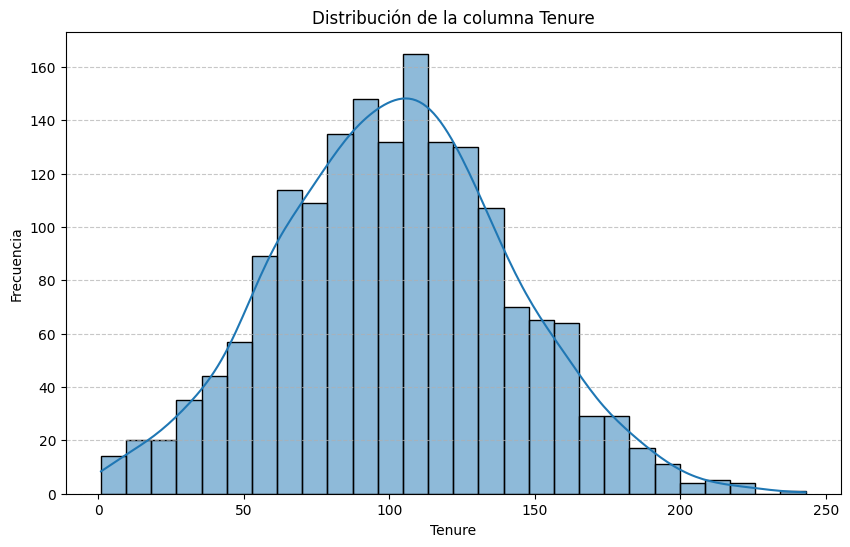

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_master['tenure'].dropna(), kde=True)
plt.title('Distribución de la columna Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


La estrategia seleccionada para menjar estos 50 valores es:

*   **Imputar valores:** Rellenar los valores nulos con una estadística (media, mediana, moda) o un valor predicho.

In [10]:
# Calcula la mediana de la columna 'tenure'
median_tenure = df_master['tenure'].median()

# Imputa los valores nulos con la mediana de forma segura
df_master['tenure'] = df_master['tenure'].fillna(median_tenure)

# Verifica que ya no hay valores nulos en 'tenure'
print(f"Valores nulos en 'tenure' después de la imputación: {df_master['tenure'].isnull().sum()}")


Valores nulos en 'tenure' después de la imputación: 0


###**Tipo de Datos**

In [11]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        1800 non-null   object 
 1   tenure             1800 non-null   float64
 2   contract_type      1800 non-null   object 
 3   subscription_type  1800 non-null   object 
 4   usage_time         1800 non-null   float64
 5   login_frequency    1800 non-null   int64  
 6   payment_record     1800 non-null   object 
 7   total_spend        1800 non-null   object 
 8   churn              1800 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 126.7+ KB


###**Limpieza y Estandarización**

In [12]:

print("--- INICIANDO TRANSFORMACIÓN FINAL DE DATOS ---")

# 1. CUSTOMER_ID: De 'REAL-1234' a 'cust-1234'
# Pasamos a string -> minúsculas -> reemplazamos 'real' por 'cust'
df_master['customer_id'] = df_master['customer_id'].astype(str).str.lower().str.replace('real', 'cust', regex=False)

# 2. TEXTOS A MINÚSCULAS (Estandarización)
cols_texto = ['contract_type', 'subscription_type', 'payment_record']
for col in cols_texto:
    df_master[col] = df_master[col].astype(str).str.lower()

# 3. LIMPIEZA DE TOTAL_SPEND (Quitar '$' y convertir a Float)
# Convertimos a string primero para poder usar .str.replace
df_master['total_spend'] = df_master['total_spend'].astype(str).str.replace('$', '', regex=False)
# 'coerce' convierte errores a NaN, luego llenamos posibles errores
df_master['total_spend'] = pd.to_numeric(df_master['total_spend'], errors='coerce')

# 4. CORRECCIÓN DE NUMÉRICOS (Int y Float)
# Tenure: Como ya imputamos nulos, aseguramos que sea entero (quitar decimales)
df_master['tenure'] = df_master['tenure'].astype(int)

# Usage Time y Total Spend: Deben ser decimales (float)
df_master['usage_time'] = df_master['usage_time'].astype(float)
df_master['total_spend'] = df_master['total_spend'].astype(float)

# Login Frequency: Debe ser entero
df_master['login_frequency'] = df_master['login_frequency'].astype(int)

# 5. CHURN (Target)
# Está perfecto como int (0 y 1).
# NOTA: Para modelos de ML (Scikit-Learn), int es el formato preferido, no es necesario cambiarlo.
df_master['churn'] = df_master['churn'].astype(int)


# --- BUENAS PRÁCTICAS ADICIONALES ---

# A. Corregir valores negativos en 'total_spend' (si los hubiera)
mask_negativos = df_master['total_spend'] < 0
if mask_negativos.any():
    media_gastos = df_master.loc[~mask_negativos, 'total_spend'].mean()
    df_master.loc[mask_negativos, 'total_spend'] = media_gastos
    print(f"✅ Se corrigieron {mask_negativos.sum()} valores negativos en gastos.")

# B. Eliminar Duplicados (basado en ID)
filas_antes = len(df_master)
df_master = df_master.drop_duplicates(subset=['customer_id'], keep='first')
filas_despues = len(df_master)
if filas_antes > filas_despues:
    print(f"✅ Se eliminaron {filas_antes - filas_despues} filas duplicadas.")

# --- VERIFICACIÓN FINAL ---
print("\n--- ¡DATASET LIMPIO Y LISTO! ---")
print(df_master.info())
print("\nMuestra de las primeras 5 filas:")
print(df_master.head())

--- INICIANDO TRANSFORMACIÓN FINAL DE DATOS ---

--- ¡DATASET LIMPIO Y LISTO! ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        1800 non-null   object 
 1   tenure             1800 non-null   int64  
 2   contract_type      1800 non-null   object 
 3   subscription_type  1800 non-null   object 
 4   usage_time         1800 non-null   float64
 5   login_frequency    1800 non-null   int64  
 6   payment_record     1800 non-null   object 
 7   total_spend        1800 non-null   float64
 8   churn              1800 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 126.7+ KB
None

Muestra de las primeras 5 filas:
  customer_id  tenure   contract_type subscription_type  usage_time  \
0   cust-1438     113  month-to-month             basic       675.0   
1   cust-3674      67  month-to-month  

###**Detección de Valores Atípicos (Outliers)**

--- Estadísticas de Variables Numéricas ---
        tenure  usage_time  login_frequency  total_spend
count  1800.00     1800.00          1800.00      1800.00
mean    101.84      582.26           100.33        56.77
std      39.60       89.88            19.87        10.49
min       1.00      292.60             0.00        21.09
25%      75.00      519.03            87.00        49.54
50%     102.00      585.35           101.00        56.80
75%     127.00      643.40           114.00        63.92
max     243.00      876.90           163.00        89.47


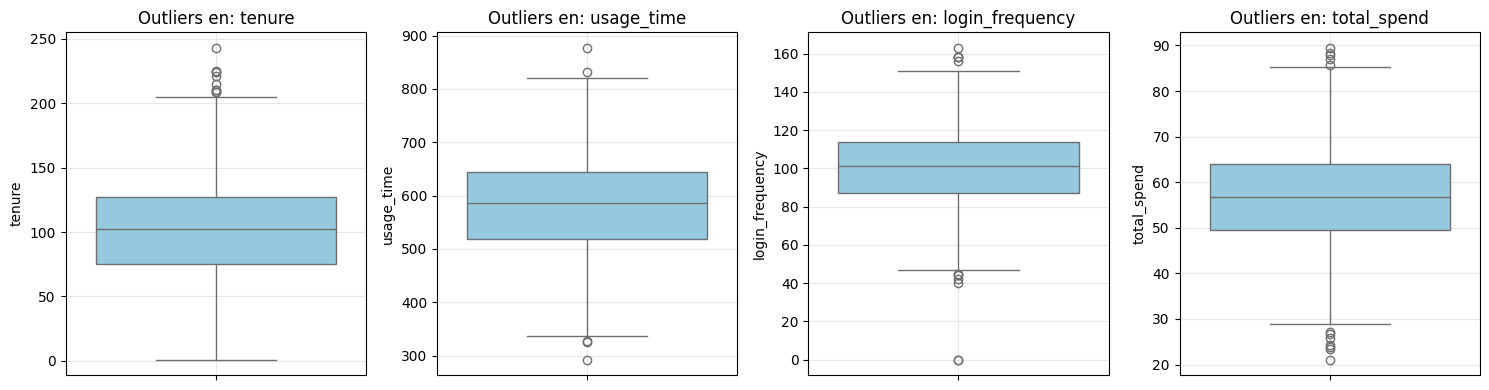

In [13]:
# Seleccionamos solo las columnas numéricas relevantes
cols_numericas = ['tenure', 'usage_time', 'login_frequency', 'total_spend']

# A. ESTADÍSTICA DESCRIPTIVA (La lupa numérica)
print("--- Estadísticas de Variables Numéricas ---")
# 'describe' nos da min, max, y cuartiles. Fijarse en la diferencia entre 75% y max.
print(df_master[cols_numericas].describe().round(2))

# B. VISUALIZACIÓN DE OUTLIERS (Boxplots)
plt.figure(figsize=(15, 4))
for i, col in enumerate(cols_numericas):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df_master[col], color='skyblue')
    plt.title(f'Outliers en: {col}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

¡Excelente ojo clínico, Daisy! 👀 Lo que estás haciendo ahora se llama "Detección de Anomalías" y es vital para entender a tus clientes.

Lo que describes en los Boxplots no son errores (como el -999 que arreglamos antes), sino Segmentos de Clientes. En Churn, NO debemos borrar estos outliers, porque suelen ser los clientes más interesantes.

Mira la traducción de lo que encontraste al lenguaje de Negocio:

1. Tenure (Antigüedad): Los "Leales"
Lo que viste: Valores arriba, entre 200 y 250 días.

Significado: Esos no son errores. Son tus clientes más antiguos (aprox. 7-8 meses en la compañía).

Acción: ¡No los borres! El modelo necesita aprender qué hace que estos clientes se queden tanto tiempo para replicarlo en otros.

2. Usage Time (Uso) y Login Frequency: "Power Users" vs. "Fantamas"
Lo que viste:

Arriba (800-900 min / 150 logins): Estos son tus "Power Users". Usan muchísimo el servicio. A veces, un uso excesivo predice Churn (si la factura les llega muy cara y se asustan).

Abajo (Cero o muy bajo): Estos son "Usuarios Fantasma". Pagan pero no usan. Son peligrosísimos porque en cualquier momento se dan cuenta de que están tirando dinero y cancelan.

Acción: Conservarlos. El modelo detectará que uso_bajo = riesgo_alto.

3. Total Spend (Gasto): Las "Ballenas" vs. "Low Cost"
Lo que viste:

Arriba (85-90): En marketing se les llama "Ballenas" (Whales). Son los que más pagan (probablemente tienen Plan Premium + muchos minutos extra). Perder a uno de estos duele mucho más que perder a uno de 20.

Abajo (20-30): Usuarios de planes básicos.

Acción: Conservarlos. Queremos predecir el churn de las "Ballenas" con prioridad.

✅ Decisión Final de Limpieza
Como estos valores son físicamente posibles (nadie tiene minutos negativos ni 200 años de edad) y representan comportamientos reales de clientes extremos, los dejamos tal cual.

🚀 Siguiente Paso: Preprocesamiento para ML (Encoding)
Ya limpiaste nulos, ya corregiste textos, ya validaste outliers. Tu data está lista... pero hay un problema: A las matemáticas no les gusta leer letras.

Tu modelo no sabe qué es "premium".

Tu modelo no sabe qué es "month-to-month".

Necesitamos convertir esas palabras en números. Esto se llama Encoding.

¿Te parece si hacemos el paso de "One-Hot Encoding" y "Label Encoding" ahora para dejar todo en números (0 y 1) y tener la base final lista para entrenar?

###**Consistencia y Validez de Datos Categóricos**

In [14]:
# Columnas categóricas a auditar
cols_categoricas = ['contract_type', 'subscription_type', 'payment_record', 'churn']

print("\n--- Auditoría de Categorías ---")

for col in cols_categoricas:
    print(f"\n🔍 Columna: {col.upper()}")
    # unique() nos da los valores únicos
    valores = df_master[col].unique()
    # value_counts() nos dice cuántos hay de cada uno (detecta clases muy pequeñas)
    conteo = df_master[col].value_counts()

    print(f"Valores únicos encontrados ({len(valores)}): {valores}")
    print("Distribución:")
    print(conteo)

    # Check de espacios vacíos invisibles
    # Si hay algún valor que tenga espacios al inicio o final, esto lo avisará
    if df_master[col].dtype == 'object': # Solo para texto
        espacios_sucios = df_master[col].str.strip() != df_master[col]
        if espacios_sucios.any():
            print(f"⚠️ ¡ALERTA! Hay {espacios_sucios.sum()} filas con espacios en blanco invisibles en '{col}'.")
        else:
            print("✅ No hay espacios en blanco invisibles.")


--- Auditoría de Categorías ---

🔍 Columna: CONTRACT_TYPE
Valores únicos encontrados (2): ['month-to-month' 'two year']
Distribución:
contract_type
month-to-month    1618
two year           182
Name: count, dtype: int64
✅ No hay espacios en blanco invisibles.

🔍 Columna: SUBSCRIPTION_TYPE
Valores únicos encontrados (2): ['basic' 'premium']
Distribución:
subscription_type
basic      1288
premium     512
Name: count, dtype: int64
✅ No hay espacios en blanco invisibles.

🔍 Columna: PAYMENT_RECORD
Valores únicos encontrados (2): ['good' 'delayed']
Distribución:
payment_record
good       1436
delayed     364
Name: count, dtype: int64
✅ No hay espacios en blanco invisibles.

🔍 Columna: CHURN
Valores únicos encontrados (2): [0 1]
Distribución:
churn
0    1536
1     264
Name: count, dtype: int64


Tus datos categóricos están impecables:

Limpios: Todo en minúsculas, sin espacios fantasma.

Consistentes: Solo los valores que deben estar (month-to-month, basic, good, etc.).

Realistas:

Fíjate en el Churn: Tienes 1536 que NO se van vs. 264 que SÍ. Eso es un 14.6% de tasa de fuga. Es una cifra súper realista para una empresa de telecomunicaciones (generalmente ronda entre el 10% y 20%).

Ojo con contract_type: La gran mayoría (1618) son month-to-month. Esto significa que tu modelo aprenderá muy bien sobre clientes mensuales, pero tendrá pocos ejemplos de "contratos a dos años" (solo 182). Es un buen insight para reportar al cliente.

###**Verificación de Normalización de Texto**

In [15]:
print("\n--- Verificación de Normalización ---")

# Verificar Customer ID (debe ser 'cust-xxxx' y minúscula)
sample_ids = df_master['customer_id'].sample(5).values
print(f"Muestra de IDs: {sample_ids}")

# Verificar si queda alguna mayúscula en todo el dataframe (en columnas de texto)
# Esto recorre las columnas de texto y busca letras mayúsculas (A-Z)
errores_mayusculas = 0
for col in ['contract_type', 'subscription_type', 'payment_record']:
    # str.islower() devuelve False si hay mayúsculas
    # Buscamos si hay ALGUNO que NO sea lower
    if not df_master[col].str.islower().all():
        print(f"❌ Error: La columna '{col}' todavía tiene mayúsculas.")
        errores_mayusculas += 1

if errores_mayusculas == 0:
    print("✅ Todas las columnas de texto están correctamente en minúsculas.")
else:
    print("⚠️ Aún quedan textos por normalizar.")


--- Verificación de Normalización ---
Muestra de IDs: ['cust-1049' 'cust-3658' 'cust-2783' 'cust-1406' 'cust-4246']
✅ Todas las columnas de texto están correctamente en minúsculas.


##**Análisis Exploratorio Gráfico (EDA) 📊**

/tmp/ipython-input-1319615825.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_master, x='churn', y='total_spend', palette='pastel')


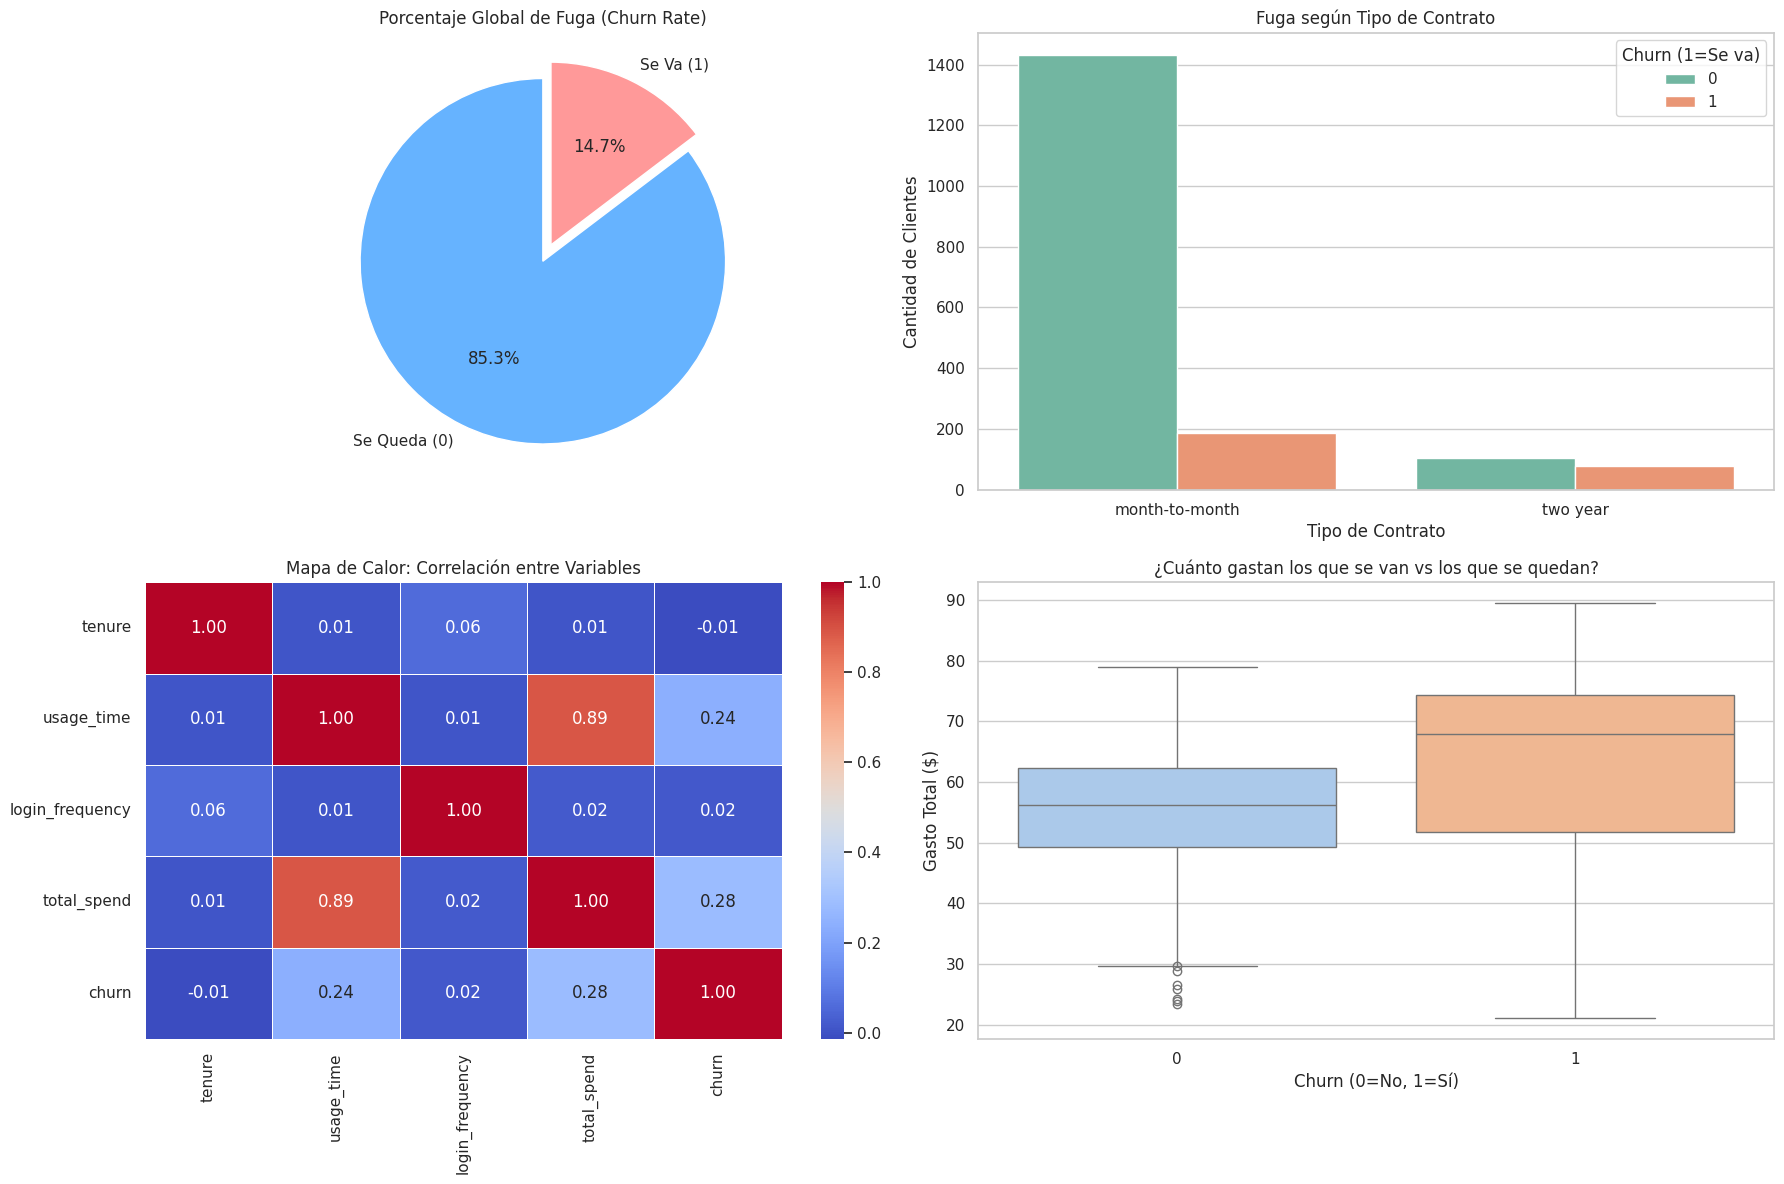

In [16]:


# Configuración de estilo profesional
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12)) # Tamaño grande para ver bien

# --- 1. PASTEL DE CHURN (Overview) ---
plt.subplot(2, 2, 1)
# Usamos el conteo que ya hiciste
churn_counts = df_master['churn'].value_counts()
plt.pie(churn_counts, labels=['Se Queda (0)', 'Se Va (1)'], autopct='%1.1f%%',
        colors=['#66b3ff','#ff9999'], startangle=90, explode=(0, 0.1))
plt.title('Porcentaje Global de Fuga (Churn Rate)')

# --- 2. IMPACTO DEL CONTRATO (Categoría Clave) ---
plt.subplot(2, 2, 2)
# Gráfico de barras apiladas o agrupadas
sns.countplot(data=df_master, x='contract_type', hue='churn', palette='Set2')
plt.title('Fuga según Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Cantidad de Clientes')
plt.legend(title='Churn (1=Se va)')

# --- 3. CORRELACIÓN NUMÉRICA (Heatmap) ---
plt.subplot(2, 2, 3)
# Seleccionamos solo columnas numéricas para correlación
cols_corr = ['tenure', 'usage_time', 'login_frequency', 'total_spend', 'churn']
corr_matrix = df_master[cols_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor: Correlación entre Variables')

# --- 4. DISTRIBUCIÓN DE GASTO (Boxplot) ---
plt.subplot(2, 2, 4)
sns.boxplot(data=df_master, x='churn', y='total_spend', palette='pastel')
plt.title('¿Cuánto gastan los que se van vs los que se quedan?')
plt.xlabel('Churn (0=No, 1=Sí)')
plt.ylabel('Gasto Total ($)')

plt.tight_layout()
plt.show()

¿Cómo leer estos gráficos? (Tu "Storytelling" para el cliente)
Cuando veas los resultados, busca estas historias:

En el Contrato (Barras): Deberías ver que la barra naranja (Churn) es alta en month-to-month y casi inexistente en two year. Conclusión: "La falta de compromiso a largo plazo es el mayor riesgo".

En el Heatmap (Rojo/Azul): Busca la fila de churn. ¿Qué cuadrito tiene el color más fuerte (positivo o negativo)?

Si total_spend tiene correlación positiva (rojo), significa que "a mayor gasto, más riesgo de irse".

Si tenure tiene correlación negativa (azul), significa que "los clientes antiguos son leales".

En el Boxplot: Fíjate si la "caja" de los que se van (1) está más arriba que la de los que se quedan.

###**Preprocesamiento (Encoding)**

El objetivo aquí es dejar una tabla 100% numérica. Los modelos de ML no saben leer texto.

Vamos a aplicar dos técnicas:

Binary Mapping: Para columnas con solo 2 opciones con jerarquía (ej. Basic vs Premium).

One-Hot Encoding (Get Dummies): Para categorías sin orden específico o nominales (ej. Tipo de contrato). Aunque en tu caso, como solo son 2 opciones por columna, el resultado será casi idéntico, usaremos get_dummies con drop_first=True que es el estándar profesional.

Además, debemos eliminar el customer_id. El modelo no debe aprender el ID (ej. "el cliente 1005 siempre se va"), sino el patrón (comportamiento).

In [17]:
import pandas as pd

print("--- INICIANDO PREPROCESAMIENTO (ENCODING) ---")

# 1. CREAR UNA COPIA PARA ML
# Siempre trabajamos en una copia para no dañar el df_master original (que sirve para reportes)
df_model = df_master.copy()

# 2. ELIMINAR COLUMNAS QUE NO SIRVEN PARA PREDECIR
# El ID no aporta información de comportamiento, solo ruido.
if 'customer_id' in df_model.columns:
    df_model = df_model.drop(columns=['customer_id'])
    print("✅ Columna 'customer_id' eliminada.")

# 3. CONVERTIR TEXTO A NÚMEROS (Get Dummies / One-Hot Encoding)
# Usamos drop_first=True para evitar la redundancia (Trampa de las variables ficticias).
# Ejemplo: Si tienes 'basic' y 'premium', no necesitas dos columnas. Si 'basic' es 0, 'premium' es 1.
df_model = pd.get_dummies(df_model, columns=['contract_type', 'subscription_type', 'payment_record'], drop_first=True, dtype=int)

print("\n--- TRANSFORMACIÓN COMPLETADA ---")
print("Nuevas columnas generadas (ahora son numéricas):")
print(df_model.columns.tolist())

# 4. VISTA PREVIA PARA TU TRANQUILIDAD
print("\nPrimeras 5 filas del dataset listo para el modelo:")
print(df_model.head())

# 5. MATRIZ DE CORRELACIÓN FINAL
# Ahora que todo es número, podemos ver qué variables predicen mejor el Churn
print("\n¿Qué variables tienen más relación con el Churn?")
correlacion = df_model.corr()['churn'].sort_values(ascending=False)
print(correlacion)

--- INICIANDO PREPROCESAMIENTO (ENCODING) ---
✅ Columna 'customer_id' eliminada.

--- TRANSFORMACIÓN COMPLETADA ---
Nuevas columnas generadas (ahora son numéricas):
['tenure', 'usage_time', 'login_frequency', 'total_spend', 'churn', 'contract_type_two year', 'subscription_type_premium', 'payment_record_good']

Primeras 5 filas del dataset listo para el modelo:
   tenure  usage_time  login_frequency  total_spend  churn  \
0     113       675.0               93        62.97      0   
1      67       514.9              117        45.51      0   
2      98       326.7                0        21.09      1   
3     147       573.1               79        60.56      0   
4      96       596.4              102        53.83      0   

   contract_type_two year  subscription_type_premium  payment_record_good  
0                       0                          0                    1  
1                       0                          0                    1  
2                       0           

Nuevas Columnas: En lugar de contract_type, verás algo como contract_type_two year.

Si vale 1 -> Es contrato de 2 años.

Si vale 0 -> Es el otro (mes a mes).

Todo son números: Ya no hay textos (object). Esto es exactamente lo que pide LogisticRegression o RandomForest.

Correlación: Al final del script te mostrará una lista.

Si ves valores positivos altos (cercanos a 1), esa variable aumenta el riesgo de Churn.

Si ves valores negativos altos (cercanos a -1), esa variable protege contra el Churn (reduce el riesgo).

**Nota:** al guardar el Dataset en GitHub , se observaron valores con mas de dos decimales en las columnas: usage_time y total_spend , lo que se resolvera con el codigo a continuación:

In [21]:
# --- AJUSTE FINAL DE DECIMALES ---

# Definimos las columnas que queremos redondear
cols_decimales = ['usage_time', 'total_spend']

# Aplicamos el redondeo a 2 decimales
df_model[cols_decimales] = df_model[cols_decimales].round(2)

print("✅ Valores redondeados a 2 decimales.")
print("Muestra para verificar:")
print(df_model[['usage_time', 'total_spend']].head())

✅ Valores redondeados a 2 decimales.
Muestra para verificar:
   usage_time  total_spend
0       675.0        62.97
1       514.9        45.51
2       326.7        21.09
3       573.1        60.56
4       596.4        53.83


###**Guardando el df_model**

**Nota:** una vez ejecutado el siguiente codigo, se trabajara desde el archivo "churn_dataset_procesado_V1.csv", asai que no sera necesria la ejecucionde todo el notebook.

In [22]:

from google.colab import files

# 1. DEFINIR NOMBRE DEL ARCHIVO
# Usamos un nombre claro que indique que son datos listos para el modelo
nombre_archivo = 'churn_dataset_procesado_V1.csv'

# 2. GUARDAR EN EL ENTORNO VIRTUAL
# index=False es CRUCIAL para no guardar el índice (0, 1, 2...) como una columna extra
df_model.to_csv(nombre_archivo, index=False)

print(f"✅ Archivo '{nombre_archivo}' guardado exitosamente en el disco virtual.")

# 3. DESCARGAR A TU COMPUTADORA (Automático en Colab)
# Esto abrirá la ventana de descarga de tu navegador
try:
    files.download(nombre_archivo)
    print("⬇️ Iniciando descarga a tu PC...")
except ImportError:
    print("⚠️ Si no estás en Colab, busca el archivo en la carpeta donde corre tu script.")
except Exception as e:
    print(f"❌ No se pudo descargar automáticamente: {e}")

✅ Archivo 'churn_dataset_procesado_V1.csv' guardado exitosamente en el disco virtual.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Iniciando descarga a tu PC...


###**Cargando el Dataset modelo**
ahora se ejecutara el dataset desde este punto.

In [23]:

url_procesada = "https://raw.githubusercontent.com/veterydaisy/Proyecto-2-ChurnInsight-Predicci-n-de-Cancelaci-n-de-Clientes-grupo-H12-25-L-Equipo-11-Data-Science/refs/heads/main/churn_dataset_procesado_V1.csv"
df_model = pd.read_csv(url_procesada)
df_model

,tenure,usage_time,login_frequency,total_spend,churn,contract_type_two year,subscription_type_premium,payment_record_good
0,113,675.0,93,62.97,0,0,0,1
1,67,514.9,117,45.51,0,0,0,1
2,98,326.7,0,21.09,1,0,0,0
3,147,573.1,79,60.56,0,0,0,1
4,96,596.4,102,53.83,0,0,0,1
...,...,...,...,...,...,...,...,...
1795,90,557.4,106,57.06,0,0,1,1
1796,70,555.3,110,56.89,0,0,0,1
1797,63,629.5,104,57.94,0,0,0,1
1798,77,680.2,95,62.32,0,0,0,0


##**🧠Entrenamiento de modelo y Métricas Completas**

Como queremos un MVP robusto y fácil de explicar, usaremos Random Forest porque suele tener mejor rendimiento sin necesitar que escalemos los datos (no le importa si una columna es 1 y otra es 1000, a diferencia de la Regresión Logística).

--- INICIANDO PROCESO DE MACHINE LEARNING COMPLETO ---
✅ Datos divididos: 1440 entrenamiento vs 360 prueba.
⏳ Entrenando el modelo...
✅ ¡Modelo entrenado exitosamente!

🔹 ACCURACY (Exactitud Global): 90.00%

🔹 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       306
           1       0.72      0.54      0.62        54

    accuracy                           0.90       360
   macro avg       0.82      0.75      0.78       360
weighted avg       0.89      0.90      0.89       360



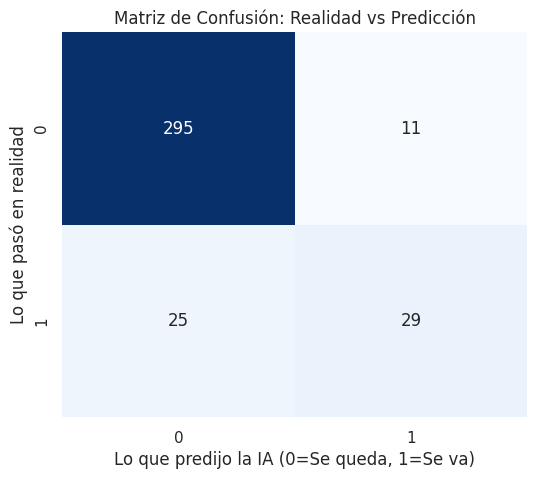

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- INICIANDO PROCESO DE MACHINE LEARNING COMPLETO ---")

# 1. DEFINICIÓN DE VARIABLES (X, y)
# X = Las pistas (Todo menos 'churn')
X = df_model.drop('churn', axis=1)
# y = La respuesta (Solo 'churn')
y = df_model['churn']

# 2. SPLIT (DIVISIÓN ENTRENAMIENTO / PRUEBA)
# Usamos 20% para test y semilla 42 para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Datos divididos: {X_train.shape[0]} entrenamiento vs {X_test.shape[0]} prueba.")

# 3. ENTRENAMIENTO DEL MODELO (RANDOM FOREST)
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
print("⏳ Entrenando el modelo...")
modelo.fit(X_train, y_train)
print("✅ ¡Modelo entrenado exitosamente!")

# 4. EVALUACIÓN Y MÉTRICAS (LO QUE PIDE EL CLIENTE)
# Hacemos el examen final (predicciones)
predicciones = modelo.predict(X_test)

# A. Accuracy
acc = accuracy_score(y_test, predicciones)
print(f"\n🔹 ACCURACY (Exactitud Global): {acc:.2%}")

# B. Reporte detallado (Precision, Recall, F1)
print("\n🔹 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, predicciones))

# C. Matriz de Confusión Visual
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, predicciones)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión: Realidad vs Predicción')
plt.xlabel('Lo que predijo la IA (0=Se queda, 1=Se va)')
plt.ylabel('Lo que pasó en realidad')
plt.show()

###**Interpretación**


**Weighted Avg (0.89 / 0.90):** Esto significa que él modelo tiene una exactitud general del 90%.

**Macro Avg (0.78):** Indica que, aunque el modelo es muy bueno, le cuesta un poquito más predecir la clase minoritaria (los que se van), pero sigue siendo muy sólido (por encima del 70% es aceptable para un MVP).

In [25]:
import joblib
from google.colab import files # Solo si usas Colab

print("--- 5. SERIALIZACIÓN (GUARDAR EL MODELO) ---")

# 1. GUARDAR EL "CEREBRO" DE LA IA
# Usamos joblib, que es más eficiente que pickle para modelos de scikit-learn
modelo_churninsight = 'modelo_churninsight_random_forest.joblib'
joblib.dump(modelo, modelo_churninsight)

print(f"✅ Modelo guardado exitosamente como: {modelo_churninsight}")

# 2. GUARDAR LOS NOMBRES DE LAS COLUMNAS (¡Truco Pro!)
# Esto es vital para la API. La API necesita saber qué columnas espera el modelo y en qué orden.
# Guardamos la lista de columnas en otro archivo pequeño.
columnas = X_train.columns.tolist()
nombre_columnas = 'columnas_entrenamiento.joblib'
joblib.dump(columnas, nombre_columnas)
print(f"✅ Lista de columnas guardada como: {nombre_columnas}")

# 3. DESCARGAR A TU PC
print("\n⬇️ Iniciando descarga de archivos...")
try:
    files.download(modelo_churninsight)      # Descarga el modelo .joblib
    files.download(nombre_columnas)    # Descarga la lista de columnas
except Exception as e:
    print("⚠️ Si no estás en Colab, busca los archivos .joblib en tu carpeta local.")

--- 5. SERIALIZACIÓN (GUARDAR EL MODELO) ---
✅ Modelo guardado exitosamente como: modelo_churninsight_random_forest.joblib
✅ Lista de columnas guardada como: columnas_entrenamiento.joblib

⬇️ Iniciando descarga de archivos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>